# Afleiden debietstatistieken

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import hkvsobekpy as hkv
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import shutil

In [4]:
# resultaten van deze cases uit dit Sobek project worden samengevoegd
pad_to_sobek = Path(r'D:\4569.20\testout_sobek\MOD_ADJ_V4.lit')
cases =range(1,12)

# binnen deze periode worden maanden beschouwd (alleen maand en dag zijn relevant)
period = pd.date_range(start=pd.Timestamp('1900-05-15'),end=pd.Timestamp('1900-09-15'), freq='D')

# geef het aantal dagen dat het deze afvoer wordt overschreden. De naam is de naam van de kolom waarmee deze in de shapefile verschijnt.
overschrijdingsduur_van_debiet = {'name': 'Ex5-9_005',  'value': 0.05}
# geef de fractie van de tijd dat het deze afvoer wordt overschreden. De naam is de naam van de kolom waarmee deze in de shapefile verschijnt.
relatieve_overschrijdingsduur_van_debiet = {'name': 'REx5-9_005',  'value': 0.05}
# geef de afvoer die dit percentiel van de tijd wordt overschreden. De naam is de naam van de kolom waarmee deze in de shapefile verschijnt.
debiet_bij_tijdpercentiel = {'name': 'Q5-9_80%',  'value': 0.8}


## Kopieer HIS-bestanden


Tijdelijk stukje om HIS-bestanden te kopieren van een andere locatie als dat nodig is (lokaal inlezen gaat sneller).

In [6]:
if False:
    litfolder = 'MOD_DEF_V4.lit'
    for case in range(1,13):
        wrkpath = Path(r'R:\pr\4569_20\SOBEK216') / litfolder / str(case) / 'work'
        if wrkpath.exists():
            srcpath = Path(r'R:\pr\4569_20\SOBEK216') / litfolder / str(case) / 'work' / 'reachseg.his'
        else:
            srcpath = Path(r'R:\pr\4569_20\SOBEK216') / litfolder / str(case) / 'reachseg.his'
        tarpath = Path(r'D:\4569.20\testout_sobek') / litfolder / str(case)
        tarpath.mkdir(parents=True, exist_ok=True)
        shutil.copy2(srcpath, tarpath)

### Lees shapefile uit Sobek export

<Axes: >

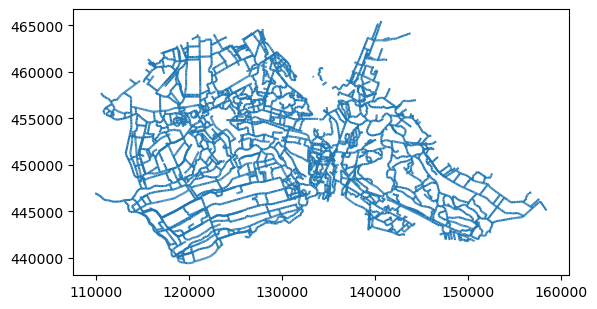

In [7]:
pad_to_export = Path(r'D:\4569.20\testout_sobek')
seg_shape = gpd.read_file(str(pad_to_export / 'RchSegments.shp'))
seg_shape.columns = [col.strip() for col in seg_shape.columns]
seg_shape.index = seg_shape['ID']
seg_shape.drop(['NAME', "TYPE", 'PARENTID', 'ID_FROM', 'ID_TO', 'USERID'], axis=1, inplace=True)
seg_shape.plot()

### Lees HIS-files uit Sobek

In [8]:
subhislist = []
for case in cases:    
    pad_to_his = str(pad_to_sobek / str(case) / 'reachseg.his')
    reachseg = hkv.read_his.ReadMetadata(pad_to_his)       
    reach_segments = reachseg.DataFrame()
    reach_segments = reach_segments.iloc[32:,:]
    locs= reachseg.GetLocations()
    params= reachseg.GetParameters()
    reach_segments = reach_segments.loc[:,params[params.index('Discharge mean(m³/s)')]]
    reach_segments.head()
    subhislist.append(reach_segments)
all_data = pd.concat(subhislist)

In [9]:
# functies om statistieken toe te voegen aan de shapefile
def overschrijdingsduur(x=None, threshold=None):
    return(len(x[x > threshold]))
def relatieve_overschrijdingsduur(x=None, threshold=None):
    return(len(x[x > threshold])/len(x))

def add_statistic(output, data, stype,overschrijdingsduur_van_debiet=None, relatieve_overschrijdingsduur_van_debiet=None,debiet_bij_tijdpercentiel=None, name=None):
    if stype=='gemiddelde':
        statcol = data.mean(axis=0)
        statcol.name = name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)        
    elif stype=='standaard_afwijking':
        statcol = data.std(axis=0)
        statcol.name = name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)        
    elif stype=='variantie':
        statcol = data.std(axis=0)**2
        statcol.name = name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)        
    elif stype=='overschrijdingsduur':
        statcol = data.apply(overschrijdingsduur, axis=0, threshold=overschrijdingsduur_van_debiet)
        statcol.name = name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)          
    elif stype=='relatieve_overschrijdingsduur':
        statcol = data.apply(relatieve_overschrijdingsduur, axis=0, threshold=relatieve_overschrijdingsduur_van_debiet)
        statcol.name = name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)          
    elif stype=='percentiel':
        statcol = data.quantile(debiet_bij_tijdpercentiel)
        statcol.name=name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)        
    else:
        print('Onbekend statistiektype. Kies uit: gemiddelde, standaard_afwijking, variantie, overschrijdingsduur, relatieve_overschrijdingsduur, percentiel')
    return(output)

Voeg kolommen toe met statistiek. We beginnen met de shapefile zelf, en voegen steeds een kolom toe met een op te geven naam.

In [10]:
sub_data = all_data[all_data.index.strftime('%m%d').isin(period.strftime('%m%d'))]
output = add_statistic(seg_shape, sub_data, 'gemiddelde', name='Av')
output = add_statistic(output, sub_data, 'variantie', name='Var')
if overschrijdingsduur_van_debiet is not None:
    output = add_statistic(output, sub_data, 'overschrijdingsduur', name=overschrijdingsduur_van_debiet['name'], overschrijdingsduur_van_debiet=overschrijdingsduur_van_debiet['value'])
if relatieve_overschrijdingsduur_van_debiet is not None:
    output = add_statistic(output, sub_data, 'relatieve_overschrijdingsduur', name=relatieve_overschrijdingsduur_van_debiet['name'], relatieve_overschrijdingsduur_van_debiet=relatieve_overschrijdingsduur_van_debiet['value'])
if debiet_bij_tijdpercentiel is not None:
    output = add_statistic(output, sub_data, 'percentiel', name=debiet_bij_tijdpercentiel['name'], debiet_bij_tijdpercentiel=debiet_bij_tijdpercentiel['value'])


Schrijf het resultaat naar een shapefile

In [ ]:
output.to_file(str(pad_to_export /  'debietstatistieken.shp'))

Klaar!

### Voorbeeld van plot

Onderstaande plot laat per watergang de fractie van de tijd zien waar een debiet van 0.005 m3/s wordt overschreden.

<Axes: >

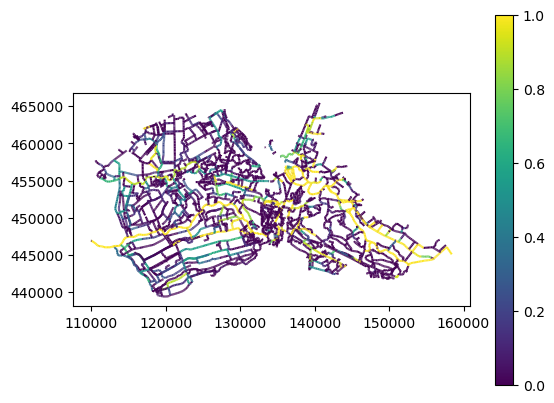

In [16]:
output.plot('REx5-9_005', legend=True)